# Cross-Section Ambiguity

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import warnings
import tqdm

import pandas_datareader.data as web
import datetime as dt

import statsmodels.api as sm
import linearmodels as lm

import matplotlib.pyplot as plt
import seaborn as sns

import mypack.data as data
import mypack.calc as calc
import mypack.plot as plot
import mypack.clas as clas

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [4]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [5]:
%matplotlib inline

In [6]:
tqdm.tqdm.pandas()

## Data

In [7]:
df_xs_estimates = pd.read_pickle('df_xs_estimates.pkl')
df_xs_predictions = pd.read_pickle('df_xs_predictions.pkl')

## Ambiguity Index

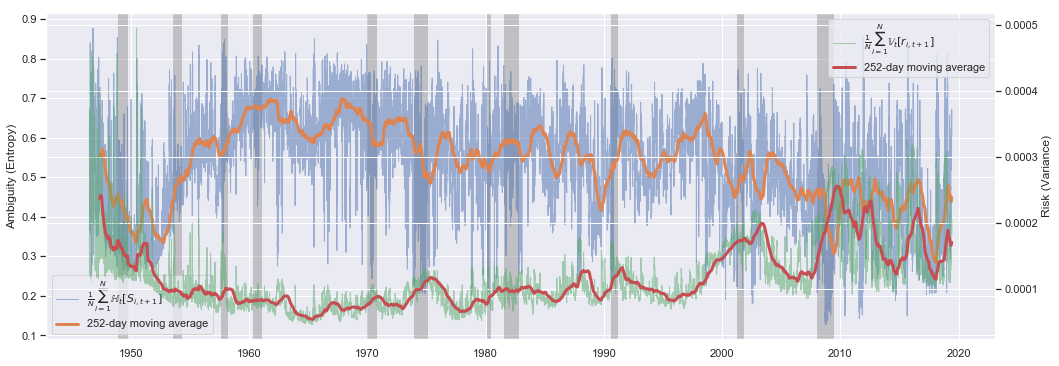

In [13]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig, ax1 = plt.subplots(figsize=[17,6])
ax2 = ax1.twinx()

ax1.plot(df_xs_predictions[1,'entropy'].groupby('Date').mean(), linewidth=1, color=cycle[0], alpha=0.5, label='$\\frac{1}{N}\sum_{i=1}^{N}\mathbb{H}_t[S_{i,t+1}]$', rasterized=True)
ax1.plot(df_xs_predictions[1,'entropy'].groupby('Date').mean().rolling(252).mean(), linewidth=3, color=cycle[1], label='252-day moving average', rasterized=True)
ax1.set_ylabel('Ambiguity (Entropy)')

ax2.plot(df_xs_predictions[1,'var'].groupby('Date').mean(), linewidth=1, color=cycle[2], alpha=0.5, label='$\\frac{1}{N}\sum_{i=1}^{N}\mathbb{V}_t[r_{i,t+1}]$', rasterized=True)
ax2.plot(df_xs_predictions[1,'var'].groupby('Date').mean().rolling(252).mean(), linewidth=3, color=cycle[3], label='252-day moving average', rasterized=True)
ax2.set_ylabel('Risk (Variance)')

ax1.legend()
ax2.legend()

plot.add_recession_bars(ax1, startdate=df_xs_predictions.index[df_xs_predictions[1,'entropy'].notna()][0][0])

plt.show()

fig.savefig('XSIndicesPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

## Calculate

### Variable Summary Stats

In [14]:
y = df_xs_predictions['data','return']#**0.5
#y = (1+df_market_predictions['data','return']).rolling(window=21).apply(np.prod, raw=True).shift(-21+1) - 1
df_xs_predictions[('data','return2')] = df_xs_predictions['data','return']**2
x = df_xs_predictions[[ 
                            (1,'mean'),
                            (1, 'var'),
                            (1, 'skew'),
                            (1, 'kurt'),
                            (1, 'entropy'),
                            #(1, 'positive'),
                            #(1, 'ks'),
                            ('data','return'),
                            ('data','return2'),
                                 ]]\
                           .reindex(columns={(1,'mean'):(1,'E'),
                                             (1,'var'):(1,'V'),
                                             (1,'skew'):(1,'S'),
                                             (1,'kurt'):(1,'K'),
                                             (1,'entropy'):(1,'H'),
                                             ('data','return'):(1,'r'),
                                             ('data','return2'):(1,'r2')}).groupby('Industry').shift(1)
x[[(1,'Dmean'),(1,'Dvar'),(1,'Dskew'),(1,'Dkurt'),(1,'Dentropy')]] = df_xs_predictions[[(1,'mean'),(1,'var'),(1,'skew'),(1,'kurt'),(1,'entropy')]]\
                .groupby('Industry').diff(1).groupby('Industry').shift(1)

#y = y.loc[y.index>=dt.datetime(1970,1,1)]
#x = x.loc[x.index>=dt.datetime(1970,1,1)]

#y = y.loc[y.index<dt.datetime(2010,1,1)]
#x = x.loc[x.index<dt.datetime(2010,1,1)]

#x = x.subtract(x.mean()).divide(x.std())

In [15]:
variable_names = ['$\mathbb{E}_t[r_{i,t+1}]$',
                  '$\mathbb{V}_t[r_{i,t+1}]$',
                  '$\mathbb{S}_t[r_{i,t+1}]$',
                  '$\mathbb{K}_t[r_{i,t+1}]$',
                  '$\mathbb{H}_t[S_{i,t+1}]$',
                  '$r_{i,t}$',
                  '$r_{i,t}^2$',
                  '$\Delta\mathbb{E}_t[r_{i,t+1}]$',
                  '$\Delta\mathbb{V}_t[r_{i,t+1}]$',
                  '$\Delta\mathbb{S}_t[r_{i,t+1}]$',
                  '$\Delta\mathbb{K}_t[r_{i,t+1}]$',
                  '$\Delta\mathbb{H}_t[S_{i,t+1}]$',
                  #'$\Delta\mathbb{P}_t[r_{i,t+1}>0]$',
                  #'$\Delta\mathbb{D}_t[\phi_{i,t+1}]$',
                  ]

order = [0,1,2,3,4,-2,-1,5,6,7,8,9]

regressors_table = pd.DataFrame(index=['N total','N (industry)','mean','std','min','median','max','skewness','kurtosis','Jarque-Bera (p)','autocorr (1)','Durbin-Watson','Aug. Dickey-Fuller (p)','']+variable_names, columns=variable_names)

regressors_table.loc['N total',:] = x.count().values
regressors_table.loc['N (industry)',:] = x.unstack().count().unstack().mean(axis=1)[order].values
regressors_table.loc['mean',:] = x.unstack().mean().unstack().mean(axis=1)[order].values
regressors_table.loc['std',:] = x.unstack().std().unstack().mean(axis=1)[order].values
regressors_table.loc['min',:] = x.unstack().min().unstack().mean(axis=1)[order].values
regressors_table.loc['median',:] = x.unstack().median().unstack().mean(axis=1)[order].values
regressors_table.loc['max',:] = x.unstack().max().unstack().mean(axis=1)[order].values
regressors_table.loc['skewness',:] = x.unstack().skew().unstack().mean(axis=1)[order].values
regressors_table.loc['kurtosis',:] = x.unstack().kurt().unstack().mean(axis=1)[order].values

#regressors_table.loc['autocorrelation (1-21)',:] = x.apply(lambda col: sum(col.autocorr(l) for l in range(1,22)), axis=0).values

regressors_table.loc['Jarque-Bera (p)',:] = x.unstack().apply(lambda col: sm.stats.stattools.jarque_bera(col[col.notna()])[1], axis=0).unstack().mean(axis=1)[order].values
regressors_table.loc['autocorr (1)',:] = x.unstack().apply(lambda col: col.autocorr(1), axis=0).unstack().mean(axis=1)[order].values
regressors_table.loc['Durbin-Watson',:] = x.unstack().apply(lambda col: sm.stats.stattools.durbin_watson(col[col.notna()])).unstack().mean(axis=1)[order].values
regressors_table.loc['Aug. Dickey-Fuller (p)',:] = x.unstack().progress_apply(lambda col: sm.tsa.stattools.adfuller(col[col.notna()], autolag='AIC')[1]).unstack().mean(axis=1)[order].values

regressors_table.loc[variable_names,:] = np.tril(x.corr().values)
regressors_table.loc[variable_names,:] = regressors_table.loc[variable_names,:].replace(0,'')

regressors_table = regressors_table.replace(np.nan,'')

calc.export_df_to_latex(regressors_table, 'XSregressors_table')

regressors_table

100%|████████████████████████████████████████████████████████████████████████████████| 588/588 [22:47<00:00,  2.11s/it]


,"$\mathbb{E}_t[r_{i,t+1}]$","$\mathbb{V}_t[r_{i,t+1}]$","$\mathbb{S}_t[r_{i,t+1}]$","$\mathbb{K}_t[r_{i,t+1}]$","$\mathbb{H}_t[S_{i,t+1}]$","$r_{i,t}$","$r_{i,t}^2$","$\Delta\mathbb{E}_t[r_{i,t+1}]$","$\Delta\mathbb{V}_t[r_{i,t+1}]$","$\Delta\mathbb{S}_t[r_{i,t+1}]$","$\Delta\mathbb{K}_t[r_{i,t+1}]$","$\Delta\mathbb{H}_t[S_{i,t+1}]$"
N total,847076,847076,847076,847076,847076,1132817,1132817,847027,847027,847027,847027,847027
N (industry),17287.2653,17287.2653,17287.2653,17287.2653,17287.2653,23118.7143,23118.7143,17286.2653,17286.2653,17286.2653,17286.2653,17286.2653
mean,0.5326,0.7554,-0.0002,-0.1046,0.0001,0.0003,0.0003,0.0000,-0.0000,0.0000,-0.0001,0.0000
std,0.2724,0.8084,0.0009,0.0824,0.0001,0.0156,0.0017,0.0003,0.0000,0.0337,0.2476,0.1513
min,0.0853,-0.0241,-0.0035,-0.4001,0.0000,-0.2203,0.0000,-0.0038,-0.0001,-0.2198,-3.6070,-0.8643
median,0.4800,0.5174,0.0000,-0.0857,0.0001,0.0003,0.0000,0.0000,-0.0000,0.0001,0.0018,-0.0042
max,1.0000,3.9620,0.0012,0.0058,0.0006,0.2844,0.1422,0.0016,0.0004,0.3368,1.6431,0.8152
skewness,0.3182,1.4433,-0.8297,-0.9333,2.3293,0.7850,30.0432,-3.7433,6.3551,1.2979,-2.5801,-0.4876
kurtosis,-1.1977,2.0875,0.4194,0.5265,14.8071,52.0102,1915.2157,33.0270,106.8962,13.9521,34.8389,4.7812
Jarque-Bera (p),0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


### Pooled Regressions

In [20]:
independents = [[0],
                [1],
                [0,1],
                [2],
                [3],
                [0,1,2,3],
                [0,1,2,3,5,6],
                [4],
                [1,4],
                [0,1,2,3,4],
                [0,1,2,3,4,5,6],
               ]

reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([['constant']+variable_names[0:7],['coefficient estimate','t-statistic','t-statistic (DK)']]), columns=range(1,len(independents)+1))

col = 0
for select in independents:
    #reg = sm.OLS(y, sm.add_constant(x.iloc[:,select]), missing='drop').fit()
    reg = lm.PanelOLS(y.swaplevel(0,1), sm.add_constant(x.swaplevel(0,1).iloc[:,select]), entity_effects=False, time_effects=False)
    regf = reg.fit()
    
    reg_table.iloc[[0]+[r*3+3 for r in select],col] = regf.params.values
    reg_table.iloc[[1]+[r*3+4 for r in select],col] = regf.tstats.values
    reg_table.iloc[[2]+[r*3+5 for r in select],col] = reg.fit(cov_type='kernel').tstats.values
    reg_table.loc['N',col+1] = int(regf.nobs)
    reg_table.loc['R$^2$ (model)',col+1] = regf.rsquared
    
    col += 1
    
calc.export_df_to_latex(reg_table, 'regressions_table_xs1')

reg_table.replace(np.nan,'')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:326: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[0])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:338: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[1])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:314: FutureWarning: .labels was deprecated in version 0.2

1       2       3   \
constant                  coefficient estimate  0.0003  0.0003  0.0002   
                          t-statistic          22.8049 11.4132  7.2789   
                          t-statistic (DK)      4.9585  3.0860  1.7493   
$\mathbb{E}_t[r_{i,t+1}]$ coefficient estimate  0.0786          0.1714   
                          t-statistic           4.9763          8.7655   
                          t-statistic (DK)      0.8442          1.6693   
$\mathbb{V}_t[r_{i,t+1}]$ coefficient estimate          0.5058  1.4157   
                          t-statistic                   3.5604  8.0464   
                          t-statistic (DK)              0.7529  2.0455   
$\mathbb{S}_t[r_{i,t+1}]$ coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
$\mathbb{K}_t[r_{i,t+1}]$ coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
$\mathbb{H}_t[S_{i,t+1}]$ coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
$r_{i,t}$                 coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
$r_{i,t}^2$               coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
N                                               847076  847076  847076   
R$^2$ (model)                                   0.0000  0.0000  0.0001   

                                                    4       5       6   \
constant                  coefficient estimate  0.0002  0.0003  0.0001   
                          t-statistic          11.8652 17.0134  3.0407   
                          t-statistic (DK)      2.2950  3.1484  0.8137   
$\mathbb{E}_t[r_{i,t+1}]$ coefficient estimate                  0.1657   
                          t-statistic                           8.0529   
                          t-statistic (DK)                      1.6550   
$\mathbb{V}_t[r_{i,t+1}]$ coefficient estimate                  1.5782   
                          t-statistic                           8.7540   
                          t-statistic (DK)                      2.2507   
$\mathbb{S}_t[r_{i,t+1}]$ coefficient estimate -0.0006         -0.0010   
                          t-statistic          -4.3564         -4.6229   
                          t-statistic (DK)     -1.3647         -2.4800   
$\mathbb{K}_t[r_{i,t+1}]$ coefficient estimate          0.0000 -0.0001   
                          t-statistic                   2.2736 -3.1278   
                          t-statistic (DK)              0.7704 -1.7527   
$\mathbb{H}_t[S_{i,t+1}]$ coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
$r_{i,t}$                 coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
$r_{i,t}^2$               coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
N                                               847076  847076  847076   
R$^2$ (model)                                   0.0000  0.0000  0.0001   

                                                    7 

In [21]:
independents = [[7],
                [8],
                [7,8],
                [9],
                [10],
                [7,8,9,10],
                [7,8,9,10,5,6],
                [11],
                [7,11],
                [7,8,9,10,11],
                [7,8,9,10,11,5,6],
               ]


reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([['constant']+variable_names,['coefficient estimate','t-statistic','t-statistic (DK)']]), columns=range(1,len(independents)+1))

col = 0
for select in independents:
    #reg = sm.OLS(y, sm.add_constant(x.iloc[:,select]), missing='drop').fit()
    reg = lm.PanelOLS(y.swaplevel(0,1), sm.add_constant(x.swaplevel(0,1).iloc[:,select]), entity_effects=False, time_effects=False)
    regf = reg.fit()
    
    reg_table.iloc[[0]+[r*3+3 for r in select],col] = regf.params.values
    reg_table.iloc[[1]+[r*3+4 for r in select],col] = regf.tstats.values
    reg_table.iloc[[2]+[r*3+5 for r in select],col] = reg.fit(cov_type='kernel').tstats.values
    reg_table.loc['N',col+1] = int(regf.nobs)
    reg_table.loc['R$^2$ (model)',col+1] = regf.rsquared
    
    col += 1

reg_table = reg_table.drop(index=variable_names[0:5])
    
calc.export_df_to_latex(reg_table, 'regressions_table_xs2')

reg_table.replace(np.nan,'')

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:326: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[0])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:338: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[1])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:314: FutureWarning: .labels was deprecated in version 0.2

1       2       3   \
constant                        coefficient estimate  0.0003  0.0003  0.0003   
                                t-statistic          22.2667 22.2598 22.2691   
                                t-statistic (DK)      4.2043  4.1841  4.2029   
$r_{i,t}$                       coefficient estimate                           
                                t-statistic                                    
                                t-statistic (DK)                               
$r_{i,t}^2$                     coefficient estimate                           
                                t-statistic                                    
                                t-statistic (DK)                               
$\Delta\mathbb{E}_t[r_{i,t+1}]$ coefficient estimate  1.0507          1.4530   
                                t-statistic          23.3568         24.9986   
                                t-statistic (DK)      8.1921         12.2417   
$\Delta\mathbb{V}_t[r_{i,t+1}]$ coefficient estimate         -3.7987  8.4679   
                                t-statistic                  -6.3330 10.9292   
                                t-statistic (DK)             -2.1638  4.9059   
$\Delta\mathbb{S}_t[r_{i,t+1}]$ coefficient estimate                           
                                t-statistic                                    
                                t-statistic (DK)                               
$\Delta\mathbb{K}_t[r_{i,t+1}]$ coefficient estimate                           
                                t-statistic                                    
                                t-statistic (DK)                               
$\Delta\mathbb{H}_t[S_{i,t+1}]$ coefficient estimate                           
                                t-statistic                                    
                                t-statistic (DK)                               
N                                                     847027  847027  847027   
R$^2$ (model)                                         0.0006  0.0000  0.0008   

                                                          4       5       6   \
constant                        coefficient estimate  0.0003  0.0003  0.0003   
                                t-statistic          22.2619 22.2611 22.2672   
                                t-statistic (DK)      4.1832  4.1811  4.2033   
$r_{i,t}$                       coefficient estimate                           
                                t-statistic                                    
                                t-statistic (DK)                               
$r_{i,t}^2$                     coefficient estimate                           
                                t-statistic                                    
                                t-statistic (DK)                               
$\Delta\mathbb{E}_t[r_{i,t+1}]$ coefficient estimate                  1.5042   
                                t-statistic                          22.8238   
                                t-statistic (DK)                     12.0866   
$\Delta\mathbb{V}_t[r_{i,t+1}]$ coefficient estimate                  6.7119   
                                t-statistic                           7.2640   
                                t-statistic (DK)                      3.2677   
$\Delta\mathbb{S}_t[r_{i,t+1}]$ coefficient estimate -0.0037         -0.0001   
                                t-statistic          -9.5388         -0.1516   
                                t-statistic (DK)     -4.5295         -0.0979   
$\Delta\mathbb{K}_t[r_{i,t+1}]$ coefficient estimate          0.0002 -0.0003   
                                t-statistic                   3.9287 -3.3552   
                                t-statistic (DK)              2.1489 -2.5599   
$\Delta\mathbb{H}_t[S_{i,t+1}]$ coefficient estimate                           
                                t-statistic              

### Panel Regressions

In [30]:
independents = [#[0],
                #[1],
                [0,1],
                #[2],
                #[3],
                #[0,1,2,3],
                #[0,1,2,3,5,6],
                [4],
                #[1,4],
                [0,1,2,3,4],
                [0,1,2,3,4,5,6],
               ]

reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([variable_names[0:7],['coefficient estimate','t-statistic','t-statistic (DK)']]), columns=range(1,len(independents)*3+1))

col = 0
for select in independents:
    for (ent,tim) in [(True,False),(False,True),(True,True)]:
        #reg = sm.OLS(y, sm.add_constant(x.iloc[:,select]), missing='drop').fit()
        reg = lm.PanelOLS(y.swaplevel(0,1), x.swaplevel(0,1).iloc[:,select], entity_effects=ent, time_effects=tim)
        regf = reg.fit()
    
        reg_table.iloc[[r*3 for r in select],col] = regf.params.values
        reg_table.iloc[[r*3+1 for r in select],col] = regf.tstats.values
        reg_table.iloc[[r*3+2 for r in select],col] = reg.fit(cov_type='kernel').tstats.values
        reg_table.loc['N',col+1] = int(regf.nobs)
        reg_table.loc['time FE',col+1] = tim
        reg_table.loc['industry FE',col+1] = ent
        reg_table.loc['R$^2$ (model)',col+1] = regf.rsquared
        reg_table.loc['R$^2$ (inclusive)',col+1] = regf.rsquared_inclusive
    
        col += 1
        print(col)
    
calc.export_df_to_latex(reg_table, 'panel_table_1')

reg_table.replace(np.nan,'')

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:326: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[0])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:338: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[1])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:314: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return list(index.levels[0][index.labels[0]].unique())


1
2


C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:619: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = self._frame.index.labels


3
4
5
6
7
8
9
10
11
12


1       2       3   \
$\mathbb{E}_t[r_{i,t+1}]$ coefficient estimate  0.1864  0.0656  0.0571   
                          t-statistic           9.1603  3.5695  2.9722   
                          t-statistic (DK)      1.7336  2.2193  1.7523   
$\mathbb{V}_t[r_{i,t+1}]$ coefficient estimate  1.8821  0.3455  0.4260   
                          t-statistic           8.8917  2.4050  2.3273   
                          t-statistic (DK)      1.9808  0.9640  0.9661   
$\mathbb{S}_t[r_{i,t+1}]$ coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
$\mathbb{K}_t[r_{i,t+1}]$ coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
$\mathbb{H}_t[S_{i,t+1}]$ coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
$r_{i,t}$                 coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
$r_{i,t}^2$               coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
N                                               847076  847076  847076   
time FE                                          False    True    True   
industry FE                                       True   False    True   
R$^2$ (model)                                   0.0001  0.0000  0.0000   
R$^2$ (inclusive)                               0.0001  0.5129  0.5129   

                                                    4       5       6   \
$\mathbb{E}_t[r_{i,t+1}]$ coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
$\mathbb{V}_t[r_{i,t+1}]$ coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
$\mathbb{S}_t[r_{i,t+1}]$ coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
$\mathbb{K}_t[r_{i,t+1}]$ coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
$\mathbb{H}_t[S_{i,t+1}]$ coefficient estimate  0.0000 -0.0001 -0.0001   
                          t-statistic           0.2333 -3.0178 -3.0324   
                          t-statistic (DK)      0.0725 -2.2545 -2.3146   
$r_{i,t}$                 coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
$r_{i,t}^2$               coefficient estimate                           
                          t-statistic                                    
                          t-statistic (DK)                               
N                                               847076  847076  847076   
time FE                                          False    True    True   
industry FE                                       True   False    True   
R$^2$ (model)                                   0.0000  0.0000  0.0000   
R$^2$ (inclusive)                               0.0000  0.5129  0.5129   

                                                    7 

In [31]:
independents = [#[7],
                #[8],
                [7,8],
                #[9],
                #[10],
                #[7,8,9,10],
                #[7,8,9,10,5,6],
                [11],
                #[7,11],
                [7,8,9,10,11],
                [7,8,9,10,11,5,6],
               ]

reg_table = pd.DataFrame(index=pd.MultiIndex.from_product([variable_names,['coefficient estimate','t-statistic','t-statistic (DK)']]), columns=range(1,len(independents)*3+1))

col = 0
for select in independents:
    for (ent,tim) in [(True,False),(False,True),(True,True)]:
        #reg = sm.OLS(y, sm.add_constant(x.iloc[:,select]), missing='drop').fit()
        reg = lm.PanelOLS(y.swaplevel(0,1), x.swaplevel(0,1).iloc[:,select], entity_effects=ent, time_effects=tim)
        regf = reg.fit()
    
        reg_table.iloc[[r*3 for r in select],col] = regf.params.values
        reg_table.iloc[[r*3+1 for r in select],col] = regf.tstats.values
        reg_table.iloc[[r*3+2 for r in select],col] = reg.fit(cov_type='kernel').tstats.values
        reg_table.loc['N',col+1] = int(regf.nobs)
        reg_table.loc['time FE',col+1] = tim
        reg_table.loc['industry FE',col+1] = ent
        reg_table.loc['R$^2$ (model)',col+1] = regf.rsquared
        reg_table.loc['R$^2$ (inclusive)',col+1] = regf.rsquared_inclusive
    
        col += 1
        print(col)

reg_table = reg_table.drop(index=variable_names[0:5])
    
calc.export_df_to_latex(reg_table, 'panel_table_2')

reg_table.replace(np.nan,'')

C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\utility.py:454: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:326: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[0])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:338: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return np.asarray(self._frame.index.labels[1])[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:314: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  return list(index.levels[0][index.labels[0]].unique())


1
2


C:\ProgramData\Anaconda3\lib\site-packages\linearmodels\panel\data.py:619: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = self._frame.index.labels


3
4
5
6
7
8
9
10
11
12


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:3812: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


1       2       3   \
$r_{i,t}$                       coefficient estimate                           
                                t-statistic                                    
                                t-statistic (DK)                               
$r_{i,t}^2$                     coefficient estimate                           
                                t-statistic                                    
                                t-statistic (DK)                               
$\Delta\mathbb{E}_t[r_{i,t+1}]$ coefficient estimate  1.4530  0.3154  0.3154   
                                t-statistic          24.9982  7.1153  7.1152   
                                t-statistic (DK)     12.2424  7.0636  7.0641   
$\Delta\mathbb{V}_t[r_{i,t+1}]$ coefficient estimate  8.4677  4.3361  4.3359   
                                t-statistic          10.9289  7.4334  7.4329   
                                t-statistic (DK)      4.9057  4.4807  4.4809   
$\Delta\mathbb{S}_t[r_{i,t+1}]$ coefficient estimate                           
                                t-statistic                                    
                                t-statistic (DK)                               
$\Delta\mathbb{K}_t[r_{i,t+1}]$ coefficient estimate                           
                                t-statistic                                    
                                t-statistic (DK)                               
$\Delta\mathbb{H}_t[S_{i,t+1}]$ coefficient estimate                           
                                t-statistic                                    
                                t-statistic (DK)                               
N                                                     847027  847027  847027   
time FE                                                False    True    True   
industry FE                                             True   False    True   
R$^2$ (model)                                         0.0008  0.0001  0.0001   
R$^2$ (inclusive)                                     0.0008  0.5130  0.5130   

                                                          4       5       6   \
$r_{i,t}$                       coefficient estimate                           
                                t-statistic                                    
                                t-statistic (DK)                               
$r_{i,t}^2$                     coefficient estimate                           
                                t-statistic                                    
                                t-statistic (DK)                               
$\Delta\mathbb{E}_t[r_{i,t+1}]$ coefficient estimate                           
                                t-statistic                                    
                                t-statistic (DK)                               
$\Delta\mathbb{V}_t[r_{i,t+1}]$ coefficient estimate                           
                                t-statistic                                    
                                t-statistic (DK)                               
$\Delta\mathbb{S}_t[r_{i,t+1}]$ coefficient estimate                           
                                t-statistic                                    
                                t-statistic (DK)                               
$\Delta\mathbb{K}_t[r_{i,t+1}]$ coefficient estimate                           
                                t-statistic                                    
                                t-statistic (DK)                               
$\Delta\mathbb{H}_t[S_{i,t+1}]$ coefficient estimate  0.0004 -0.0001 -0.0001   
                                t-statistic           4.4920 -1.0696 -1.0697   
                                t-statistic (DK)      1.7211 -0.7802 -0.7802   
N                                                     847027  847027  847027   
time FE                                                Fa

### Portfolio Sorts

#### Single Sorts

In [40]:
n_portfolios = 5

In [236]:
y = df_xs_predictions['data','return']
x1 = df_xs_predictions[1,'mean']
x2 = df_xs_predictions[1,'var']
x3 = df_xs_predictions[1,'entropy']

In [243]:
single_sorts_table = pd.DataFrame()

for x in [x1,x2,x3]:
    # sort
    portfolio_returns, portfolio_assets, portfolio_mapping = calc.sort_portfolios(y.unstack(),x.unstack(),n_portfolios,return_assets=True)
    
    # spreading returns
    portfolio_returns['5-1'] = portfolio_returns[n_portfolios]-portfolio_returns[1]
    
    # output table
    sorted_portfolios = pd.DataFrame(index = portfolio_returns.columns)
    sorted_portfolios['mean'] = portfolio_returns.mean()
    sorted_portfolios['std'] = portfolio_returns.std()
    sorted_portfolios['T'] = portfolio_returns.count()
    sorted_portfolios['average N'] = portfolio_assets[portfolio_assets>0].mean()
    sorted_portfolios['t-stat'] = sorted_portfolios['mean']/(sorted_portfolios['std']/sorted_portfolios['T']**0.5)
    sorted_portfolios['return p.a.'] = sorted_portfolios['mean']*252
    sorted_portfolios['volatility p.a.'] = sorted_portfolios['std'] * (252**0.5)
    sorted_portfolios['SR'] = sorted_portfolios['return p.a.']/sorted_portfolios['volatility p.a.']
    sorted_portfolios.replace(np.nan,'')
    sorted_portfolios.index = pd.MultiIndex.from_product([[x.name[1]],['low']+list(sorted_portfolios.index)[1:-2]+['high','high-low']])
    
    # combine
    single_sorts_table = single_sorts_table.append(sorted_portfolios)
    #single_sorts_table.index = single_sorts_table.index+pd.MultiIndex.from_tuples([("","")])
    single_sorts_table = single_sorts_table.append(pd.Series(name=("","")))
    
single_sorts_table = single_sorts_table.iloc[:-1]
single_sorts_table.index.set_levels(['','$\mathbb{H}_t[S_{i,t+1}]$','$\mathbb{E}_t[r_{i,t+1}]$','$\mathbb{V}_t[r_{i,t+1}]$'],level=0,inplace=True)

single_sorts_table.replace(np.nan,'')
single_sorts_table[single_sorts_table.isna()] = ''

calc.export_df_to_latex(single_sorts_table,'single_sorts_table')

single_sorts_table

mean    std          T average N  \
$\mathbb{E}_t[r_{i,t+1}]$ low       0.0003 0.0111 18536.0000    9.4001   
                          2         0.0003 0.0099 18536.0000    8.9374   
                          3         0.0003 0.0093 18536.0000    9.0241   
                          4         0.0003 0.0091 18536.0000    8.9374   
                          high      0.0004 0.0084 18536.0000    9.4001   
                          high-low  0.0001 0.0060 18536.0000             
                                                                         
$\mathbb{V}_t[r_{i,t+1}]$ low       0.0003 0.0074 18536.0000    9.4001   
                          2         0.0003 0.0088 18536.0000    8.9374   
                          3         0.0003 0.0094 18536.0000    9.0241   
                          4         0.0003 0.0102 18536.0000    8.9374   
                          high      0.0003 0.0118 18536.0000    9.4001   
                          high-low  0.0000 0.0070 18536.0000             
                                                                         
$\mathbb{H}_t[S_{i,t+1}]$ low       0.0003 0.0102 18536.0000    9.4001   
                          2         0.0003 0.0097 18536.0000    8.9374   
                          3         0.0004 0.0095 18536.0000    9.0241   
                          4         0.0003 0.0093 18536.0000    8.9374   
                          high      0.0002 0.0090 18536.0000    9.4001   
                          high-low -0.0001 0.0051 18536.0000             

                                    t-stat return p.a. volatility p.a.      SR  
$\mathbb{E}_t[r_{i,t+1}]$ low       3.3144      0.0683          0.1768  0.3865  
                          2         3.9923      0.0731          0.1570  0.4655  
                          3         4.5538      0.0783          0.1475  0.5310  
                          4         4.5315      0.0761          0.1441  0.5284  
                          high      5.9489      0.0927          0.1337  0.6936  
                          high-low  2.2126      0.0244          0.0947  0.2580  
                                                                                
$\mathbb{V}_t[r_{i,t+1}]$ low       5.7282      0.0789          0.1181  0.6679  
                          2         4.9419      0.0805          0.1398  0.5762  
                          3         3.7008      0.0646          0.1498  0.4315  
                          4         4.5471      0.0863          0.1627  0.5302  
                          high      3.6212      0.0793          0.1879  0.4222  
                          high-low  0.0354      0.0005          0.1117  0.0041  
                                                                                
$\mathbb{H}_t[S_{i,t+1}]$ low       4.3326      0.0820          0.1623  0.5052  
                          2         4.4494      0.0796          0.1535  0.5188  
                          3         5.3625      0.0943          0.1508  0.6253  
                          4         4.2130      0.0724          0.1475  0.4912  
                          high      3.6951      0.0618          0.1435  0.4308  
                          high-low -2.1266     -0.0201          0.0812 -0.2480

#### Simultaneous Double Sorts

In [291]:
n_portfolios_1 = 3
n_portfolios_2 = 3

In [292]:
y = df_xs_predictions['data','return']
x1 = df_xs_predictions[1, 'var']
x2 = df_xs_predictions[1, 'entropy']

In [297]:
double_portfolio_returns, double_portfolio_assets, double_portfolio_mapping = calc.double_sort_portfolios_simultaneously(y.unstack(), x1.unstack(), x2.unstack(), n_portfolios_1 ,n_portfolios_2, return_assets=True)

double_portfolio_returns['1,3 - 1,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['1,1']
double_portfolio_returns['2,3 - 2,1'] = double_portfolio_returns['2,3']-double_portfolio_returns['2,1']
double_portfolio_returns['3,3 - 3,1'] = double_portfolio_returns['3,3']-double_portfolio_returns['3,1']

sim_double_sorts_table = pd.DataFrame(index = double_portfolio_returns.columns)
sim_double_sorts_table['mean'] = double_portfolio_returns.mean()
sim_double_sorts_table['std'] = double_portfolio_returns.std()
sim_double_sorts_table['T'] = double_portfolio_returns.count()
sim_double_sorts_table['average N'] = double_portfolio_assets[double_portfolio_assets>0].mean()
sim_double_sorts_table['t-stat'] = sim_double_sorts_table['mean']/(sim_double_sorts_table['std']/sim_double_sorts_table['T']**0.5)
sim_double_sorts_table['return p.a.'] = sim_double_sorts_table['mean']*252
sim_double_sorts_table['volatility p.a.'] = sim_double_sorts_table['std'] * (252**0.5)
sim_double_sorts_table['SR'] = sim_double_sorts_table['return p.a.']/sim_double_sorts_table['volatility p.a.']

sim_double_sorts_table.index = ['low,low']+list(sim_double_sorts_table.index)[1:-4]+['high,high','low,high-low,low','mid,high-mid,low','high,high-high,low']
sim_double_sorts_table = sim_double_sorts_table.rename_axis('$\mathbb{V}_t[r_{i,t+1}],\mathbb{H}_t[S_{i,t+1}]$', axis=0)

sim_double_sorts_table.replace(np.nan,'')
sim_double_sorts_table[sim_double_sorts_table.isna()] = ''

calc.export_df_to_latex(sim_double_sorts_table,'sim_double_sorts_table')

sim_double_sorts_table

,mean,std,T,average N,t-stat,return p.a.,volatility p.a.,SR
"$\mathbb{V}_t[r_{i,t+1}],\mathbb{H}_t[S_{i,t+1}]$",,,,,,,,
"low,low",0.0003,0.0083,18411,4.7352,5.0608,0.0782,0.1321,0.5921
"1,2",0.0004,0.0083,18533,5.8925,6.0436,0.0924,0.1311,0.7047
"1,3",0.0003,0.0081,18379,4.4040,4.9009,0.0738,0.1286,0.5739
"2,1",0.0003,0.0101,18528,5.3452,4.2135,0.0785,0.1598,0.4914
"2,2",0.0003,0.0097,18527,5.3634,3.8772,0.0699,0.1545,0.4522
"2,3",0.0002,0.0095,18519,5.0771,3.2420,0.0569,0.1504,0.3782
"3,1",0.0004,0.0126,18429,4.9438,4.0028,0.0940,0.2008,0.4681
"3,2",0.0004,0.0121,18501,4.5323,4.8727,0.1096,0.1927,0.5687
"high,high",0.0003,0.0113,18445,5.5496,3.1566,0.0664,0.1800,0.3690


#### Sequential Double Sorts

In [294]:
n_portfolios_1 = 3
n_portfolios_2 = 3

In [295]:
y = df_xs_predictions['data','return']
x1 = df_xs_predictions[1, 'var']
x2 = df_xs_predictions[1, 'entropy']

In [298]:
double_portfolio_returns, double_portfolio_assets, double_portfolio_mapping = calc.double_sort_portfolios(y.unstack(), x1.unstack(), x2.unstack(), n_portfolios_1 ,n_portfolios_2, return_assets=True)

double_portfolio_returns['1,3 - 1,1'] = double_portfolio_returns['1,3']-double_portfolio_returns['1,1']
double_portfolio_returns['2,3 - 2,1'] = double_portfolio_returns['2,3']-double_portfolio_returns['2,1']
double_portfolio_returns['3,3 - 3,1'] = double_portfolio_returns['3,3']-double_portfolio_returns['3,1']

seq_double_sorts_table = pd.DataFrame(index = double_portfolio_returns.columns)
seq_double_sorts_table['mean'] = double_portfolio_returns.mean()
seq_double_sorts_table['std'] = double_portfolio_returns.std()
seq_double_sorts_table['T'] = double_portfolio_returns.count()
seq_double_sorts_table['average N'] = double_portfolio_assets[double_portfolio_assets>0].mean()
seq_double_sorts_table['t-stat'] = seq_double_sorts_table['mean']/(seq_double_sorts_table['std']/seq_double_sorts_table['T']**0.5)
seq_double_sorts_table['return p.a.'] = seq_double_sorts_table['mean']*252
seq_double_sorts_table['volatility p.a.'] = seq_double_sorts_table['std'] * (252**0.5)
seq_double_sorts_table['SR'] = seq_double_sorts_table['return p.a.']/seq_double_sorts_table['volatility p.a.']

seq_double_sorts_table.index = ['low,low']+list(seq_double_sorts_table.index)[1:-4]+['high,high','low,high-low,low','mid,high-mid,low','high,high-high,low']
seq_double_sorts_table = seq_double_sorts_table.rename_axis('$\mathbb{V}_t[r_{i,t+1}],\mathbb{H}_t[S_{i,t+1}]$', axis=0)

seq_double_sorts_table.replace(np.nan,'')
seq_double_sorts_table[seq_double_sorts_table.isna()] = ''

calc.export_df_to_latex(seq_double_sorts_table,'seq_double_sorts_table')

seq_double_sorts_table

,mean,std,T,average N,t-stat,return p.a.,volatility p.a.,SR
"$\mathbb{V}_t[r_{i,t+1}],\mathbb{H}_t[S_{i,t+1}]$",,,,,,,,
"low,low",0.0003,0.0081,18536,4.9847,5.4430,0.0821,0.1293,0.6346
"1,2",0.0004,0.0081,18536,4.9920,5.8969,0.0890,0.1294,0.6876
"1,3",0.0003,0.0080,18536,4.9847,4.8847,0.0722,0.1267,0.5696
"2,1",0.0003,0.0100,18536,5.3760,4.2767,0.0791,0.1587,0.4987
"2,2",0.0003,0.0098,18536,5.0241,3.7870,0.0685,0.1552,0.4416
"2,3",0.0002,0.0094,18536,5.3760,3.5560,0.0618,0.1492,0.4146
"3,1",0.0003,0.0126,18536,4.9847,3.6611,0.0852,0.1995,0.4269
"3,2",0.0004,0.0119,18536,4.9920,4.4570,0.0985,0.1895,0.5197
"high,high",0.0003,0.0112,18536,4.9847,3.0755,0.0637,0.1777,0.3586
